## The lending club ia peer to peer lending site where members make loans to each other
## Business Problem:How can we predict interest rates based on borrower and loan    attributes.


# PRE MODELLING

In [163]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [164]:
data = pd.read_csv('LoansData.csv')

In [165]:
data.head()

,LoanID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,1,20000.0,20000.0,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year
1,2,19200.0,19200.0,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years
2,3,35000.0,35000.0,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years
3,4,10000.0,9975.0,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years
4,5,12000.0,12000.0,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years


In [166]:
data.shape

(2500, 15)

In [167]:
data.dtypes # Finding the data types of each column

LoanID                              int64
Amount.Requested                  float64
Amount.Funded.By.Investors        float64
Interest.Rate                      object
Loan.Length                        object
Loan.Purpose                       object
Debt.To.Income.Ratio               object
State                              object
Home.Ownership                     object
Monthly.Income                    float64
FICO.Range                         object
Open.CREDIT.Lines                 float64
Revolving.CREDIT.Balance          float64
Inquiries.in.the.Last.6.Months    float64
Employment.Length                  object
dtype: object

## Get rid of duplicate rows or any other duplicates if required

In [168]:
data.duplicated().value_counts()

False    2500
dtype: int64

In [169]:
data.isnull().sum() # Finding no. of missing values in each column

LoanID                             0
Amount.Requested                   1
Amount.Funded.By.Investors         1
Interest.Rate                      2
Loan.Length                        0
Loan.Purpose                       0
Debt.To.Income.Ratio               1
State                              0
Home.Ownership                     1
Monthly.Income                     1
FICO.Range                         2
Open.CREDIT.Lines                  3
Revolving.CREDIT.Balance           3
Inquiries.in.the.Last.6.Months     3
Employment.Length                 77
dtype: int64

### Pandas_Profiling
#### Provides you with a Audit Report For Exploratory Data Analysis 

In [170]:
import pandas_profiling 

In [171]:
profile_report=pandas_profiling.ProfileReport(data)

In [172]:
profile_report.to_file("profile_report.html")

# MODELING
## Select Algorithm
### It is a Regression problem and we are using Linear Regression algorithm to solve it

## Data Preparation I
## Fix Problem Identified at the Pre-Modeling Stage
Column names are not as per the pythonic way of doing thing

Type Casting

Create New Variables (FICO)

Missing Values

May be dealing with outliers

Have Categorical Variables i.e. Have to encode them

Dealing with features with high cardinality --> Have to drop the variable bcz only the ID var has high cardinality

### Column names in order

In [173]:
data.columns=data.columns.str.replace(".","_")

### Type Casting
Interest_Rate

Loan_Length

Debt_To_Income_Ratio

Employment_Length

In [174]:
data['Interest_Rate']=data['Interest_Rate'].apply(lambda x:float(str(x).replace("%","")))
data['Debt_To_Income_Ratio'] = data['Debt_To_Income_Ratio'].apply(lambda x: float(str(x).replace('%','')))

In [175]:
data['Employment_Length'] = data['Employment_Length'].apply(lambda x: str(x).replace('< ',''))
data['Employment_Length'] = data['Employment_Length'].apply(lambda x: str(x).replace('+',''))
data['Employment_Length'] = data['Employment_Length'].apply(lambda x: str(x).replace(' years',''))
data['Employment_Length'] = data['Employment_Length'].apply(lambda x: float(str(x).replace(' year','')))

In [176]:
data['Loan_Length'] = data['Loan_Length'].apply(lambda x: float(str(x).replace(' months','')))

#### Create New Variables (FICO)

In [177]:
data[['Fico_low','Fico_high']] = data.FICO_Range.str.split('-', expand=True)

In [178]:
data.Fico_low = data.Fico_low.astype("float")
data.Fico_high = data.Fico_high.astype("float")
data['Fico_avg'] = ((data.Fico_low+data.Fico_high)/2)

In [179]:
numeric_var_names=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

['LoanID', 'Amount_Requested', 'Amount_Funded_By_Investors', 'Interest_Rate', 'Loan_Length', 'Debt_To_Income_Ratio', 'Monthly_Income', 'Open_CREDIT_Lines', 'Revolving_CREDIT_Balance', 'Inquiries_in_the_Last_6_Months', 'Employment_Length', 'Fico_low', 'Fico_high', 'Fico_avg']
['Loan_Purpose', 'State', 'Home_Ownership', 'FICO_Range']


In [180]:
data_num = data[numeric_var_names]
data_cat = data[cat_var_names]

In [181]:
def outlier_miss_treat(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    x = x.fillna(x.median())
    return x

In [182]:
data_num_new=data_num.apply(outlier_miss_treat)

In [183]:
def miss_treat(x):
    x = x.fillna(x.mode().iloc[0])
    return (x)

In [184]:
data_cat_new = data_cat.apply(miss_treat)

In [185]:
data_cat_new.count()

Loan_Purpose      2500
State             2500
Home_Ownership    2500
FICO_Range        2500
dtype: int64

In [186]:
data_num_new.count()

LoanID                            2500
Amount_Requested                  2500
Amount_Funded_By_Investors        2500
Interest_Rate                     2500
Loan_Length                       2500
Debt_To_Income_Ratio              2500
Monthly_Income                    2500
Open_CREDIT_Lines                 2500
Revolving_CREDIT_Balance          2500
Inquiries_in_the_Last_6_Months    2500
Employment_Length                 2500
Fico_low                          2500
Fico_high                         2500
Fico_avg                          2500
dtype: int64

In [187]:
del data_cat_new['FICO_Range']

In [188]:
data_cat_new2 = pd.get_dummies(data_cat_new, drop_first=True)

In [189]:
data_new = pd.concat([data_num_new, data_cat_new2], axis=1)

In [190]:
data_new.shape

(2500, 76)

In [191]:
data_new.head()

,LoanID,Amount_Requested,Amount_Funded_By_Investors,Interest_Rate,Loan_Length,Debt_To_Income_Ratio,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,...,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Home_Ownership_NONE,Home_Ownership_OTHER,Home_Ownership_OWN,Home_Ownership_RENT
0,25.99,20000.0,20000.0,8.90,36.0,14.90,6541.67,14.0,14272.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,25.99,19200.0,19200.0,12.12,36.0,28.36,4583.33,12.0,11140.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,25.99,35000.0,35000.0,21.98,60.0,23.81,11500.00,14.0,21977.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,25.99,10000.0,9975.0,9.99,36.0,14.30,3833.33,10.0,9346.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,25.99,12000.0,12000.0,11.71,36.0,18.78,3195.00,11.0,14469.0,0.0,...,0,0,0,0,0,0,0,0,0,1


# Data Preparation Level II (Determining Assumptions)

 ## Y should follow normal distribution.
Can be solved by transforming the Y variable and using this transformed Y variable for creating the model

In [192]:
from matplotlib import pyplot as plt
import seaborn as sns

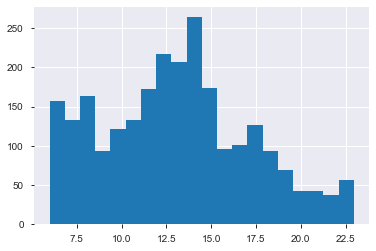

In [193]:
data_new.Interest_Rate.hist(bins=20)

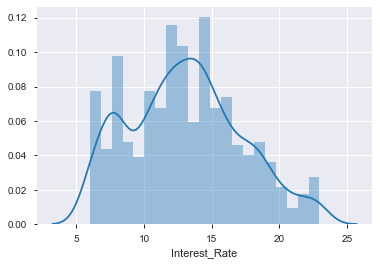

In [194]:
sns.distplot(data_new.Interest_Rate)

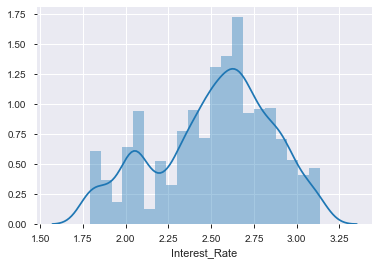

In [195]:
sns.distplot(np.log(data_new.Interest_Rate)) # Taking Log transormation

In [196]:
data_new['ln_Y']=np.log(data_new.Interest_Rate)

In [197]:
data_new.head()

,LoanID,Amount_Requested,Amount_Funded_By_Investors,Interest_Rate,Loan_Length,Debt_To_Income_Ratio,Monthly_Income,Open_CREDIT_Lines,Revolving_CREDIT_Balance,Inquiries_in_the_Last_6_Months,...,State_VT,State_WA,State_WI,State_WV,State_WY,Home_Ownership_NONE,Home_Ownership_OTHER,Home_Ownership_OWN,Home_Ownership_RENT,ln_Y
0,25.99,20000.0,20000.0,8.90,36.0,14.90,6541.67,14.0,14272.0,2.0,...,0,0,0,0,0,0,0,0,0,2.186051
1,25.99,19200.0,19200.0,12.12,36.0,28.36,4583.33,12.0,11140.0,1.0,...,0,0,0,0,0,0,0,0,0,2.494857
2,25.99,35000.0,35000.0,21.98,60.0,23.81,11500.00,14.0,21977.0,1.0,...,0,0,0,0,0,0,0,0,0,3.090133
3,25.99,10000.0,9975.0,9.99,36.0,14.30,3833.33,10.0,9346.0,0.0,...,0,0,0,0,0,0,0,0,0,2.301585
4,25.99,12000.0,12000.0,11.71,36.0,18.78,3195.00,11.0,14469.0,0.0,...,0,0,0,0,0,0,0,0,1,2.460443


## There should be correlation between x and Y variable
Can Create a Linear Regression Model as a number of x variables are correlated with the Y

In [198]:
data_num_new.corrwith(data_num_new.Interest_Rate)

LoanID                            0.020067
Amount_Requested                  0.330780
Amount_Funded_By_Investors        0.335694
Interest_Rate                     1.000000
Loan_Length                       0.423147
Debt_To_Income_Ratio              0.173002
Monthly_Income                    0.036206
Open_CREDIT_Lines                 0.083050
Revolving_CREDIT_Balance          0.083611
Inquiries_in_the_Last_6_Months    0.170408
Employment_Length                 0.052629
Fico_low                         -0.712008
Fico_high                        -0.712008
Fico_avg                         -0.712008
dtype: float64

### There should be no multicollinearity i.e. X variables should not be highly correlated to each other

In [199]:
corrm=data_num_new.corr()

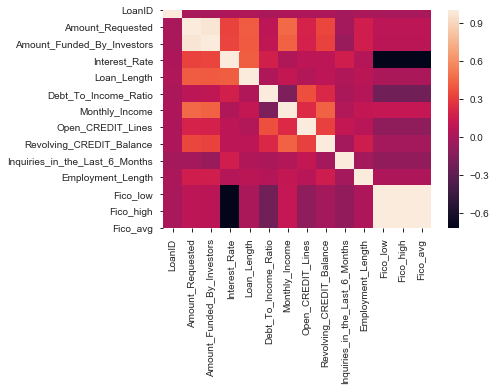

In [200]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(data_num_new.corr())

## Data Preparation III (Feature Engineering – Feature Reduction)

In [201]:
del data_new['LoanID']
del data_new['Fico_low']
del data_new['Fico_high']

#### Corr between x and Y

In [202]:
data_num_new.corrwith(data_num_new.Interest_Rate)

LoanID                            0.020067
Amount_Requested                  0.330780
Amount_Funded_By_Investors        0.335694
Interest_Rate                     1.000000
Loan_Length                       0.423147
Debt_To_Income_Ratio              0.173002
Monthly_Income                    0.036206
Open_CREDIT_Lines                 0.083050
Revolving_CREDIT_Balance          0.083611
Inquiries_in_the_Last_6_Months    0.170408
Employment_Length                 0.052629
Fico_low                         -0.712008
Fico_high                        -0.712008
Fico_avg                         -0.712008
dtype: float64

In [203]:
column_names=pd.Series(list(data_num_new.corrwith(data_num_new.Interest_Rate).index),name='Column_Names')
r_values=pd.Series(list(data_num_new.corrwith(data_num_new.Interest_Rate)),name='r_values')
corr = pd.concat([column_names,r_values],axis=1)
corr['r_values_abs'] = np.abs(corr.r_values)
corr = corr.sort_values(by=['r_values_abs'],ascending=False)

### Correlation between the x variables
Can remove Amount Funded By Investors

In [204]:
features=data_new[data_new.columns.difference(['ln_Y', 'Interest_Rate'])]

In [205]:
target= data_new['ln_Y']

### Recursive Feature Elimination

In [206]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [207]:
#INITIALIZATION
lm=LinearRegression()

In [208]:
# Fit the model on the data 
# create the RFE model and select 10 attributes

rfe=RFE(lm,n_features_to_select=10)
rfe=rfe.fit(features,target)

In [209]:
select_cols= rfe.get_support()

In [210]:
features.columns[select_cols]

Index(['Home_Ownership_NONE', 'Home_Ownership_OTHER',
       'Loan_Purpose_debt_consolidation', 'Loan_Purpose_house',
       'Loan_Purpose_moving', 'Loan_Purpose_other', 'State_HI', 'State_MT',
       'State_SD', 'State_VT'],
      dtype='object')

### F Regression (Univariate Regression)

In [211]:
from sklearn.feature_selection import f_regression

In [212]:
F_values, p_values=f_regression(features, target )
F_values = pd.Series(F_values)
p_values = pd.Series(p_values)
cols = pd.Series(features.columns)
f_vars = pd.concat([cols,F_values,p_values],axis=1)
f_vars.columns = ['col','f_val','p_val']
f_vars = f_vars.sort_values(by=['f_val'],ascending=False)
f_vars.head(10)

,col,f_val,p_val
4,Fico_avg,3100.724445,0.000000e+00
10,Loan_Length,438.267854,8.536924e-90
0,Amount_Funded_By_Investors,251.201192,5.558841e-54
1,Amount_Requested,250.674653,7.067959e-54
2,Debt_To_Income_Ratio,82.469906,2.122468e-19
9,Inquiries_in_the_Last_6_Months,81.193740,3.966141e-19
12,Loan_Purpose_debt_consolidation,45.372662,2.014570e-11
16,Loan_Purpose_major_purchase,31.624958,2.078118e-08
14,Loan_Purpose_home_improvement,24.097597,9.747763e-07
8,Home_Ownership_RENT,18.616762,1.660250e-05


### Select K Best

In [213]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

In [214]:
selector = SelectKBest(f_classif, k=10)

In [215]:
selector.fit(features, target)

SelectKBest(k=10, score_func=<function f_classif at 0x000001C983DFBDC8>)

In [216]:
selector.get_support()

array([ True, False, False, False,  True,  True,  True, False, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [217]:
K_Best=features.columns[selector.get_support()]

In [218]:
pd.Series(K_Best)

0        Amount_Funded_By_Investors
1                          Fico_avg
2               Home_Ownership_NONE
3              Home_Ownership_OTHER
4    Inquiries_in_the_Last_6_Months
5                       Loan_Length
6          Loan_Purpose_educational
7                          State_IA
8                          State_IN
9                          State_MS
dtype: object

### Variance Inflation Factor

In [219]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [220]:
VIF=[variance_inflation_factor(features.values,i) for i in range(features.shape[1])]

In [221]:
VIF_results = pd.concat([pd.Series(features.columns), pd.Series(VIF)],axis=1)
VIF_results.columns = ['Feature','VIF']
VIF_results = VIF_results.sort_values('VIF',ascending=False)

In [222]:
VIF_results2 = VIF_results.sort_values('VIF',ascending=True)

In [223]:
VIF_results2.head(10)

,Feature,VIF
5,Home_Ownership_NONE,1.014079
20,Loan_Purpose_renewable_energy,1.102329
40,State_IN,1.219600
71,State_WY,1.259167
7,Home_Ownership_OWN,1.260485
63,State_SD,1.285235
13,Loan_Purpose_educational,1.302235
67,State_VT,1.344174
15,Loan_Purpose_house,1.396254
22,Loan_Purpose_vacation,1.403844


In [225]:
Selected_vars = list(Selected_vars)

In [226]:
data_new1 = data_new.loc[:,['Amount_Requested',
'Loan_Length',
'Debt_To_Income_Ratio',
'Inquiries_in_the_Last_6_Months',
'Fico_avg',
'Loan_Purpose_debt_consolidation',
'Loan_Purpose_major_purchase',
'Loan_Purpose_home_improvement',
'Home_Ownership_RENT',
'Revolving_CREDIT_Balance',
'Open_CREDIT_Lines',
'Home_Ownership_NONE',
'Home_Ownership_OTHER',
'Loan_Purpose_credit_card',
'Loan_Purpose_house',
'Loan_Purpose_moving',
'Loan_Purpose_other',
'Loan_Purpose_small_business',
'Loan_Purpose_vacation',
'Loan_Purpose_wedding',
'Loan_Purpose_educational',
'Loan_Purpose_medical',
'Loan_Purpose_renewable_energy',
'Employment_Length']]

In [227]:
data_new1.head()

,Amount_Requested,Loan_Length,Debt_To_Income_Ratio,Inquiries_in_the_Last_6_Months,Fico_avg,Loan_Purpose_debt_consolidation,Loan_Purpose_major_purchase,Loan_Purpose_home_improvement,Home_Ownership_RENT,Revolving_CREDIT_Balance,...,Loan_Purpose_house,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding,Loan_Purpose_educational,Loan_Purpose_medical,Loan_Purpose_renewable_energy,Employment_Length
0,20000.0,36.0,14.90,2.0,737.0,1,0,0,0,14272.0,...,0,0,0,0,0,0,0,0,0,1.0
1,19200.0,36.0,28.36,1.0,717.0,1,0,0,0,11140.0,...,0,0,0,0,0,0,0,0,0,2.0
2,35000.0,60.0,23.81,1.0,692.0,1,0,0,0,21977.0,...,0,0,0,0,0,0,0,0,0,2.0
3,10000.0,36.0,14.30,0.0,697.0,1,0,0,0,9346.0,...,0,0,0,0,0,0,0,0,0,5.0
4,12000.0,36.0,18.78,0.0,697.0,0,0,0,1,14469.0,...,0,0,0,0,0,0,0,0,0,9.0


In [228]:
data_new1.shape

(2500, 24)

In [230]:
data_new1['ln_Interest_Rate'] = data_new.ln_Y

In [231]:
data_new1.head()

,Amount_Requested,Loan_Length,Debt_To_Income_Ratio,Inquiries_in_the_Last_6_Months,Fico_avg,Loan_Purpose_debt_consolidation,Loan_Purpose_major_purchase,Loan_Purpose_home_improvement,Home_Ownership_RENT,Revolving_CREDIT_Balance,...,Loan_Purpose_moving,Loan_Purpose_other,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding,Loan_Purpose_educational,Loan_Purpose_medical,Loan_Purpose_renewable_energy,Employment_Length,ln_Interest_Rate
0,20000.0,36.0,14.90,2.0,737.0,1,0,0,0,14272.0,...,0,0,0,0,0,0,0,0,1.0,2.186051
1,19200.0,36.0,28.36,1.0,717.0,1,0,0,0,11140.0,...,0,0,0,0,0,0,0,0,2.0,2.494857
2,35000.0,60.0,23.81,1.0,692.0,1,0,0,0,21977.0,...,0,0,0,0,0,0,0,0,2.0,3.090133
3,10000.0,36.0,14.30,0.0,697.0,1,0,0,0,9346.0,...,0,0,0,0,0,0,0,0,5.0,2.301585
4,12000.0,36.0,18.78,0.0,697.0,0,0,0,1,14469.0,...,0,0,0,0,0,0,0,0,9.0,2.460443


In [232]:
# Data Preparation IV (Resampling data)

from sklearn.model_selection import train_test_split

train, test = train_test_split( data_new1, test_size = 0.3, random_state = 1234 )

print(len(train))
print(len(test))

1750
750


## Model Implementation

In [233]:
data_new1.columns

Index(['Amount_Requested', 'Loan_Length', 'Debt_To_Income_Ratio',
       'Inquiries_in_the_Last_6_Months', 'Fico_avg',
       'Loan_Purpose_debt_consolidation', 'Loan_Purpose_major_purchase',
       'Loan_Purpose_home_improvement', 'Home_Ownership_RENT',
       'Revolving_CREDIT_Balance', 'Open_CREDIT_Lines', 'Home_Ownership_NONE',
       'Home_Ownership_OTHER', 'Loan_Purpose_credit_card',
       'Loan_Purpose_house', 'Loan_Purpose_moving', 'Loan_Purpose_other',
       'Loan_Purpose_small_business', 'Loan_Purpose_vacation',
       'Loan_Purpose_wedding', 'Loan_Purpose_educational',
       'Loan_Purpose_medical', 'Loan_Purpose_renewable_energy',
       'Employment_Length', 'ln_Interest_Rate'],
      dtype='object')

In [234]:
import statsmodels.formula.api as smf

In [235]:
my_formula='ln_Interest_Rate~Amount_Requested+Loan_Length+Debt_To_Income_Ratio+Inquiries_in_the_Last_6_Months+Fico_avg+Loan_Purpose_debt_consolidation+Loan_Purpose_major_purchase+Loan_Purpose_home_improvement+Home_Ownership_RENT+Revolving_CREDIT_Balance+Open_CREDIT_Lines+Home_Ownership_NONE+Home_Ownership_OTHER+Loan_Purpose_credit_card+Loan_Purpose_house+Loan_Purpose_moving+Loan_Purpose_other+Loan_Purpose_small_business+Loan_Purpose_vacation+Loan_Purpose_wedding+Loan_Purpose_educational+Loan_Purpose_medical+Loan_Purpose_renewable_energy+Employment_Length'

In [236]:
model=smf.ols(my_formula,data=train).fit()

In [237]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       ln_Interest_Rate   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     260.7
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:16:35   Log-Likelihood:                 738.23
No. Observations:                1750   AIC:                            -1428.
Df Residuals:                    1726   BIC:                            -1297.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Nelglecting the features which have p values > 0.05

In [239]:
my_formula='ln_Interest_Rate~Amount_Requested+Loan_Length+Inquiries_in_the_Last_6_Months+Fico_avg+Revolving_CREDIT_Balance+Open_CREDIT_Lines+Loan_Purpose_wedding'

In [240]:
model = smf.ols(my_formula, data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       ln_Interest_Rate   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     844.9
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:21:23   Log-Likelihood:                 722.68
No. Observations:                1750   AIC:                            -1429.
Df Residuals:                    1742   BIC:                            -1386.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### POST MODELING
### Model Validation
### Predciting the Y on the train dataset

In [245]:
train['pred']=pd.DataFrame(np.exp(model.predict(train)))

In [246]:
train.head()

,Amount_Requested,Loan_Length,Debt_To_Income_Ratio,Inquiries_in_the_Last_6_Months,Fico_avg,Loan_Purpose_debt_consolidation,Loan_Purpose_major_purchase,Loan_Purpose_home_improvement,Home_Ownership_RENT,Revolving_CREDIT_Balance,...,Loan_Purpose_other,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding,Loan_Purpose_educational,Loan_Purpose_medical,Loan_Purpose_renewable_energy,Employment_Length,ln_Interest_Rate,pred
42,5500.0,36.0,3.58,1.0,662.0,0,0,0,1,0.0,...,0,0,0,0,0,0,0,8.0,2.951258,15.943190
108,10000.0,36.0,10.59,3.0,692.0,1,0,0,1,10390.0,...,0,0,0,0,0,0,0,1.0,2.645465,13.769027
1577,8000.0,36.0,8.91,0.0,757.0,0,0,0,1,680.0,...,0,0,0,0,0,1,0,6.0,2.066863,7.919326
237,12375.0,36.0,22.42,0.0,682.0,1,0,0,0,12226.0,...,0,0,0,0,0,0,0,3.0,2.615204,14.092818
1436,3200.0,36.0,16.72,4.0,667.0,0,0,0,0,80837.0,...,0,0,0,0,0,0,0,10.0,2.534490,14.640030


In [247]:
test['pred'] = pd.DataFrame(np.exp(model.predict(test)))
test.head()

,Amount_Requested,Loan_Length,Debt_To_Income_Ratio,Inquiries_in_the_Last_6_Months,Fico_avg,Loan_Purpose_debt_consolidation,Loan_Purpose_major_purchase,Loan_Purpose_home_improvement,Home_Ownership_RENT,Revolving_CREDIT_Balance,...,Loan_Purpose_other,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding,Loan_Purpose_educational,Loan_Purpose_medical,Loan_Purpose_renewable_energy,Employment_Length,ln_Interest_Rate,pred
903,12500.0,36.0,11.71,0.0,782.0,0,0,1,0,1052.0,...,0,0,0,0,0,0,0,2.0,2.232163,6.856472
674,2500.0,36.0,24.07,3.0,667.0,0,1,0,0,2684.0,...,0,0,0,0,0,0,0,1.0,2.769459,15.107493
1624,21700.0,36.0,13.93,2.0,697.0,0,0,0,0,8795.0,...,0,0,0,0,0,0,0,5.0,2.728506,15.105154
1214,21000.0,60.0,11.27,0.0,712.0,1,0,0,0,19431.0,...,0,0,0,0,0,0,0,8.0,2.658159,15.768187
2164,4400.0,36.0,17.93,1.0,767.0,0,1,0,0,9945.0,...,0,0,0,0,0,0,0,5.0,1.790091,7.131724


In [248]:
test['Interest_Rate'] = np.exp(test.ln_Interest_Rate)

In [251]:
train['Interest_Rate'] = np.exp(train.ln_Interest_Rate)

In [252]:
train.head()

,Amount_Requested,Loan_Length,Debt_To_Income_Ratio,Inquiries_in_the_Last_6_Months,Fico_avg,Loan_Purpose_debt_consolidation,Loan_Purpose_major_purchase,Loan_Purpose_home_improvement,Home_Ownership_RENT,Revolving_CREDIT_Balance,...,Loan_Purpose_small_business,Loan_Purpose_vacation,Loan_Purpose_wedding,Loan_Purpose_educational,Loan_Purpose_medical,Loan_Purpose_renewable_energy,Employment_Length,ln_Interest_Rate,pred,Interest_Rate
42,5500.0,36.0,3.58,1.0,662.0,0,0,0,1,0.0,...,0,0,0,0,0,0,8.0,2.951258,15.943190,19.13
108,10000.0,36.0,10.59,3.0,692.0,1,0,0,1,10390.0,...,0,0,0,0,0,0,1.0,2.645465,13.769027,14.09
1577,8000.0,36.0,8.91,0.0,757.0,0,0,0,1,680.0,...,0,0,0,0,1,0,6.0,2.066863,7.919326,7.90
237,12375.0,36.0,22.42,0.0,682.0,1,0,0,0,12226.0,...,0,0,0,0,0,0,3.0,2.615204,14.092818,13.67
1436,3200.0,36.0,16.72,4.0,667.0,0,0,0,0,80837.0,...,0,0,0,0,0,0,10.0,2.534490,14.640030,12.61


### Model Evaluation

In [250]:
from sklearn import metrics
import scipy.stats as stats

### Train Evaluation

In [253]:
MAPE_train = np.mean(np.abs(train.Interest_Rate - train.pred)/train.Interest_Rate )
print('MAPE_train',MAPE_train)

MAPE_train 0.12040714095077457


In [254]:
RMSE_train = metrics.mean_squared_error(train.Interest_Rate , train.pred)
print('RMSE_train',RMSE_train)

RMSE_train 3.7723440086628366


In [255]:
Corr_train = stats.stats.pearsonr(train.Interest_Rate , train.pred)
print('Corr_train',Corr_train)

Corr_train (0.8843330769274428, 0.0)


In [256]:
MAPE_test = np.mean(np.abs(test.Interest_Rate - test.pred)/test.Interest_Rate )
print('MAPE_test',MAPE_test)

RMSE_test = metrics.mean_squared_error(test.Interest_Rate , test.pred)
print('RMSE_test',RMSE_test)

Corr_test = stats.stats.pearsonr(test.Interest_Rate , test.pred)
print('Corr_test',Corr_test)

MAPE_test 0.12406755070178957
RMSE_test 3.730973532885164
Corr_test (0.8848129643486601, 2.7108697046206958e-250)


### Decile Analysis

In [257]:
train['Deciles']=pd.qcut(train['pred'],10, labels=False)

In [258]:
train.head()

,Amount_Requested,Loan_Length,Debt_To_Income_Ratio,Inquiries_in_the_Last_6_Months,Fico_avg,Loan_Purpose_debt_consolidation,Loan_Purpose_major_purchase,Loan_Purpose_home_improvement,Home_Ownership_RENT,Revolving_CREDIT_Balance,...,Loan_Purpose_vacation,Loan_Purpose_wedding,Loan_Purpose_educational,Loan_Purpose_medical,Loan_Purpose_renewable_energy,Employment_Length,ln_Interest_Rate,pred,Interest_Rate,Deciles
42,5500.0,36.0,3.58,1.0,662.0,0,0,0,1,0.0,...,0,0,0,0,0,8.0,2.951258,15.943190,19.13,8
108,10000.0,36.0,10.59,3.0,692.0,1,0,0,1,10390.0,...,0,0,0,0,0,1.0,2.645465,13.769027,14.09,6
1577,8000.0,36.0,8.91,0.0,757.0,0,0,0,1,680.0,...,0,0,0,1,0,6.0,2.066863,7.919326,7.90,0
237,12375.0,36.0,22.42,0.0,682.0,1,0,0,0,12226.0,...,0,0,0,0,0,3.0,2.615204,14.092818,13.67,6
1436,3200.0,36.0,16.72,4.0,667.0,0,0,0,0,80837.0,...,0,0,0,0,0,10.0,2.534490,14.640030,12.61,7


In [259]:
avg_actual = train[['Deciles','Interest_Rate']].groupby(train.Deciles).mean().sort_index(ascending=False)['Interest_Rate']

In [261]:
avg_pred = train[['Deciles','pred']].groupby(train.Deciles).mean().sort_index(ascending=False)['pred']

In [263]:
#Decile analysis - Test
test['Deciles']=pd.qcut(test['pred'],10, labels=False)

avg_actual_test = test[['Deciles','Interest_Rate']].groupby(test.Deciles).mean().sort_index(ascending=False)['Interest_Rate']
avg_pred_test = test[['Deciles','pred']].groupby(test.Deciles).mean().sort_index(ascending=False)['pred']

In [264]:
Decile_analysis_test = pd.concat([avg_actual_test, avg_pred_test], axis=1)

In [265]:
Decile_analysis_test.reset_index()

,Deciles,Interest_Rate,pred
0,9,19.702255,20.203275
1,8,16.572667,16.086487
2,7,15.734933,14.958247
3,6,14.526933,14.154341
4,5,13.481067,13.308206
5,4,12.442400,12.400434
6,3,11.384933,11.379457
7,2,9.977600,10.305029
8,1,8.446987,9.012567
9,0,7.189520,7.080534


### Analysis of Residuals

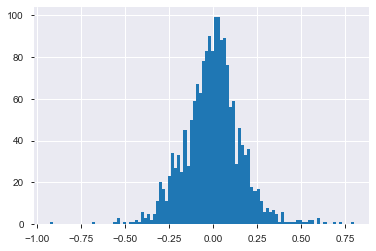

In [266]:
model.resid.hist(bins=100)